> # TODO
>
> - Faster data loading
>   - Convert jpej images to bmp or HDF5
>   - Use **libjpeg-turbo** or **PyVips** or **pillow-simd** to speed up jpeg image I/O from the disk.
>   - Use **albumentations**for GPU utilization.
>   - Try [Nvidia Dali](https://github.com/NVIDIA/DALI) for GPU loading and augmentation
> - Better data
>   - Balance the data
>   - Custom mean and std for the dataset?
> - Better model
>   - Try better models (resnet34, resnet50)
> - Bigger input size (480) using adaptative pooling, final layers then:
>   - -> [AdaptiveAvgPool2d((1, 1))](https://pytorch.org/docs/stable/nn.html#adaptiveavgpool2d) -> Linear
>   - -> Conv2d(512, 4, 3, padding=1) -> AdaptiveAvgPool2d(1) -> view(input.size(0), -1) -> LogSoftmax()
> - Bigger batch size
> - Metrics: mAP
> - Metrics: Confusion matrix
> - Metrics: 10-fold crossvalidation

> # DONE
> - [1 Cycle](https://github.com/nachiket273/One_Cycle_Policy/blob/master/CLR.ipynb) (superconvergence)
> - Use [lr_finder](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)
> - 2nd train unfreezed (or partially unfreezed)
> - Fix num_workers = 4  (no es posible en windows)
> - Set validation and test set and train
> - Metrics
>   - Loss
>   - Accuracy

# Import javIA framework

In [1]:
from javIA_oop import *

AI framework by Javi based in PyTorch: 0.4.1


# Load data

OBJETIVO: dataset.shape = (2828, 3, 720, 480)

In [2]:
class HistologyDataset(ImageDataset):

	def __init__(self, transforms=False, limit=False):
		data_dir_ssd = pathlib.Path("C:/Users/Javi/Desktop/Datasets/histologyDS2828")
		data_dir_hdd = pathlib.Path("D:/Datasets/TFM/histologyDS2828")
		csv_file     = data_dir_ssd / "imageClasses.txt"
		csv_df       = pd.read_csv(csv_file, header=None, delim_whitespace=True, names=['Image', 'Label'])

		self.image_dir  = data_dir_ssd / "imgs"
		self.images     = (csv_df["Image"]).values
		self.labels     = (csv_df["Label"]-1).values
		self.labels_map = {0: "conective tissue", 1: "ephitelial tissue", 2: "muscular tissue", 3: "nervous tissue"}
		self.transforms = transforms
		self.limit      = limit


dataset    = HistologyDataset()
print("There are", len(dataset), "images in the dataset.")

There are 2828 images in the dataset.


# Check if data is balanced

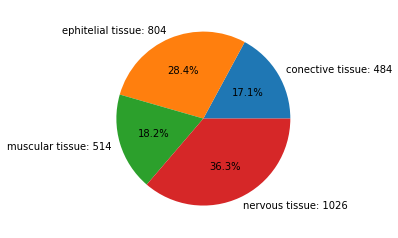

In [3]:
dataset.plot_balance()

# Show data

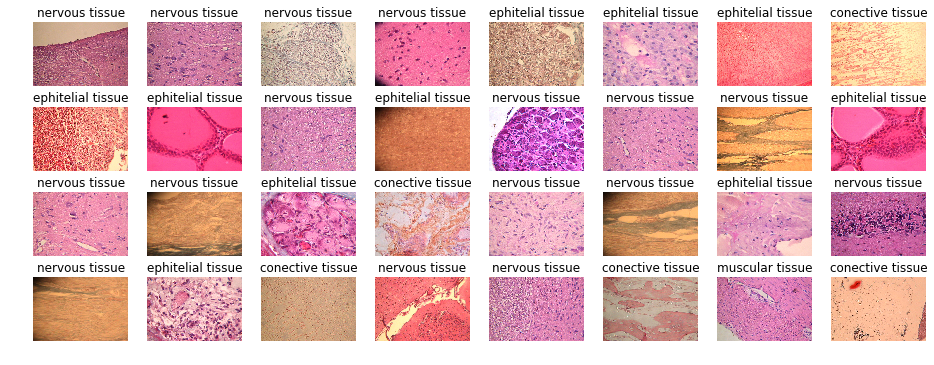

In [4]:
dataset.plot_images()

# Add transforms

In [5]:
data_transforms = transforms.Compose([
    transforms.CenterCrop(320),
    #transforms.Pad(64, padding_mode='reflect'),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset.transforms = data_transforms

# Model: Resnet 18

In [6]:
#dl = DeepLearner("resnet18", dataset, dataset, half_prec=False)
dl = DeepLearner("resnet18", dataset, dataset, half_prec=False, balance=True)

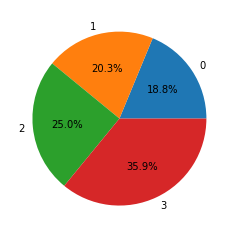

In [35]:
t = next(iter(dl.train_batches))[1]
unique_labels, counts_labels = np.unique(t.numpy(), return_counts=True)
plt.pie(counts_labels, labels=unique_labels, autopct='%1.1f%%');

# LR finder

 55%|████████████████████████████████████████████                                    | 55/100 [00:29<00:23,  1.93it/s]

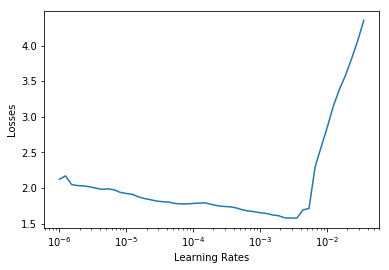

In [7]:
dl.findLR(start_lr=1e-6, end_lr=1e-2)

# Train old

In [5]:
learning_rate = 0.01
momentum      = 0.9
weight_decay  = 1e-4
batch_size    = 16 #64

# Optimizer
optimizer = get_optimizer(model, learning_rate, momentum, weight_decay)

Total time: 00:09
Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1/5	0.487460	0.000118	0.750000	1.000000   (00:02)
2/5	0.000000	0.000000	1.000000	1.000000   (00:01)
3/5	0.000000	0.000000	1.000000	1.000000   (00:01)
4/5	0.000000	0.000000	1.000000	1.000000   (00:01)
5/5	0.000000	0.000000	1.000000	1.000000   (00:01)

Training complete in 0m 9s
Best val Acc: 1.000000


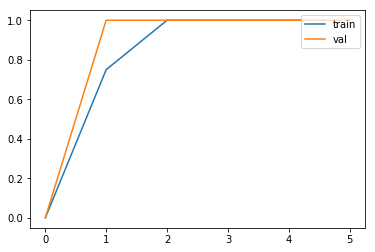

In [6]:
train_old(model, optimizer, criterion, dataset2, batch_size, num_epochs=5, half=half_precision) #4

In [ ]:
unfreeze(model)

In [ ]:
train(num_epochs=3)

# Train

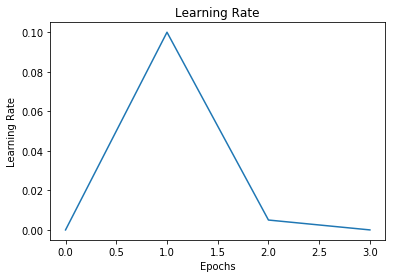

In [7]:
epochs         = [0,1,2,3] #[0, 15, 30, 35]
learning_rates = [0, 0.1, 0.005, 0]
momentum       = [0.95, 0.8, 0.94, 0.95]
num_workers    = 0  # 4 for linux
batch_size     = 64
optimizer      = get_optimizer(model)

plot_lr(epochs, learning_rates)

Total time: 03:34
Epoch	Time	LearRate	T_loss	T_accu		V_loss	V_accu                      
----------------------------------------------------------------------
1/3	1:12	0.1000		0.0213	0.3667		0.0177	0.5410                           (01:12)
2/3	2:24	0.0050		0.0170	0.5477		0.0151	0.6559                           (01:11)
3/3	3:35	0.0000		0.0162	0.5905		0.0151	0.6623                           (01:11)



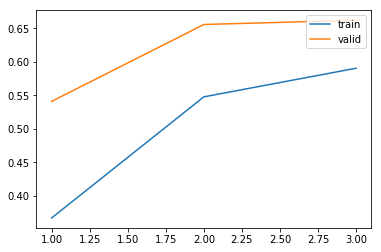

In [8]:
summary = train(model, epochs, learning_rates, optimizer, criterion, dataset, batch_size)

Total time: 03:32
Epoch	Time	LearRate	T_loss	T_accu		V_loss	V_accu                      
----------------------------------------------------------------------
1/3	1:11	0.1000		0.0159	0.6124		0.0138	0.7076                           (01:11)
2/3	2:22	0.0050		0.0148	0.6421		0.0128	0.7366                           (01:10)
3/3	3:33	0.0000		0.0143	0.6584		0.0127	0.7291                           (01:10)



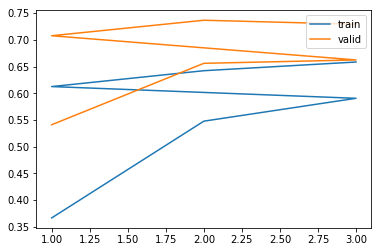

In [11]:
unfreeze(model)
summary = train(model, epochs, learning_rates, optimizer, criterion, dataset, batch_size)

# Buscar cuellos de botella

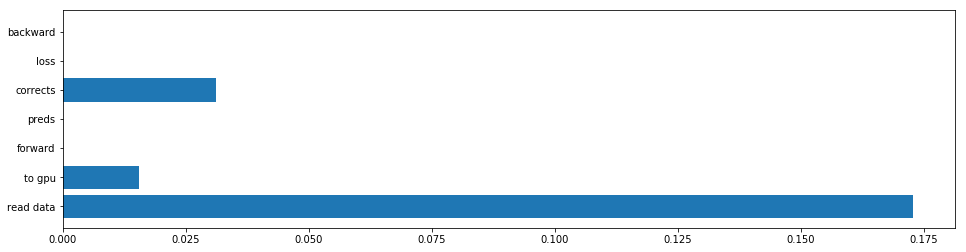

In [6]:
dataloader = torch.utils.data.DataLoader(dataset["train"], batch_size, shuffle=True)
plot_bottleneck(model, criterion, optimizer, dataloader, batch_size)

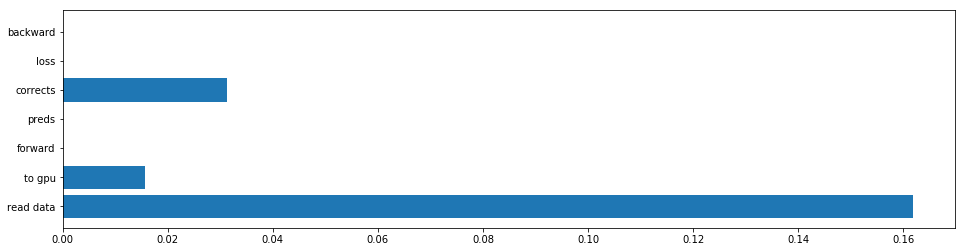

In [9]:
plot_bottleneck(model, criterion, optimizer, dataloader, batch_size)

# Confusion matrix

In [ ]:
plot_confusion(model, dataset)